In [42]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split
from keras import layers, Model
from keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers, layers, losses
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, PrecisionRecallDisplay
from keras.utils import plot_model
import pandas as pd
import seaborn as sns
import joblib

(39000, 14)


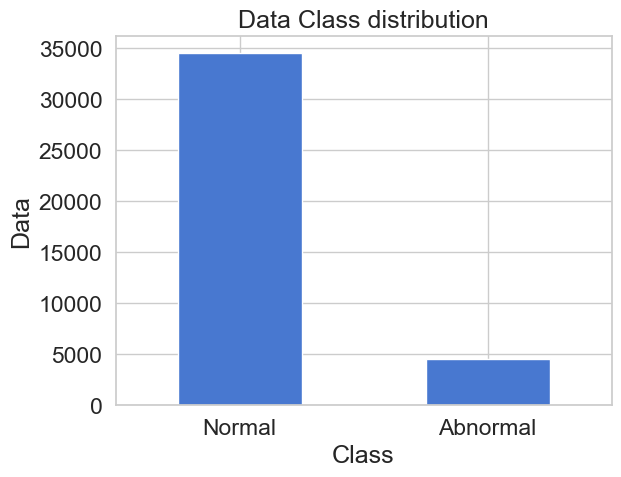

In [3]:
# Generate some sample data for the autoencoder
# x_train = np.random.rand(1000, 12)
# x_test = np.random.rand(100, 12)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42

df = pd.read_csv("Autoencoder1.csv")  
print(df.shape)

LABELS = ["Normal", "Abnormal"]

count_classes =pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from cmath import pi

data = df.drop(['Time'], axis=1)
y_true = df['Class']

r2d = 180/pi

data['P'] = r2d * data['P']
data['Q'] = r2d * data['Q']
data['R'] = r2d * data['R']
data['Phi'] = r2d * data['Phi']
data['Theta'] = r2d * data['Theta']
data['Psi'] = r2d * data['Psi']

In [4]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']
X_train = pd.DataFrame(X_train)
X_train = X_train.drop(['Class'], axis=1)

# X_test = X_test[X_test.Class == 0]
y_test = X_test['Class']
X_test = pd.DataFrame(X_test)
X_test = X_test.drop(['Class'], axis=1)

def normalize(label):
    str = StandardScaler()
    str.fit(X_train[label].values.reshape(-1, 1))
    X_train[label] = str.transform(X_train[label].values.reshape(-1, 1))
    X_test[label] = str.transform(X_test[label].values.reshape(-1, 1))

def normalize1(label):
    str = MinMaxScaler()
    str.fit(X_train[label].values.reshape(-1, 1))
    X_train[label] = str.transform(X_train[label].values.reshape(-1, 1))
    X_test[label] = str.transform(X_test[label].values.reshape(-1, 1))

A = ['RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'P', 'Q', 'R', 'Phi', 'Theta', 'Psi']

for i in A:
    normalize1(i)

X_train = X_train.values
X_test = X_test.values

In [5]:
input_dim = 12
latent_dim = 4

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            layers.Dense(8, activation='sigmoid',
                        activity_regularizer=regularizers.l2(10e-3)),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.Dense(8, activation='relu'),
            layers.Dense(input_dim, activation='tanh'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-21 10:16:10.650480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-21 10:16:10.650970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-21 10:16:10.863836: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2023-02-21 10:16:11.134465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3625/3625 [==============================] - ETA: 0s - loss: 0.0403

2023-02-21 10:16:27.855959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: DAGMM/assets
3625/3625 [==============================] - 23s 6ms/step - loss: 0.0403 - val_loss: 0.0200
Epoch 2/5
3625/3625 [==============================] - 23s 6ms/step - loss: 0.0184 - val_loss: 0.0166
Epoch 3/5
3625/3625 [==============================] - 23s 6ms/step - loss: 0.0157 - val_loss: 0.0148
Epoch 4/5
3625/3625 [==============================] - 23s 6ms/step - loss: 0.0140 - val_loss: 0.0134
Epoch 5/5
3625/3625 [==============================] - 23s 6ms/step - loss: 0.0132 - val_loss: 0.0129
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 4)                 140       
                                                                 
 sequential_1 (Sequential)   (None, 12)                148       
                                                                 
Total params: 288
Trainable params:

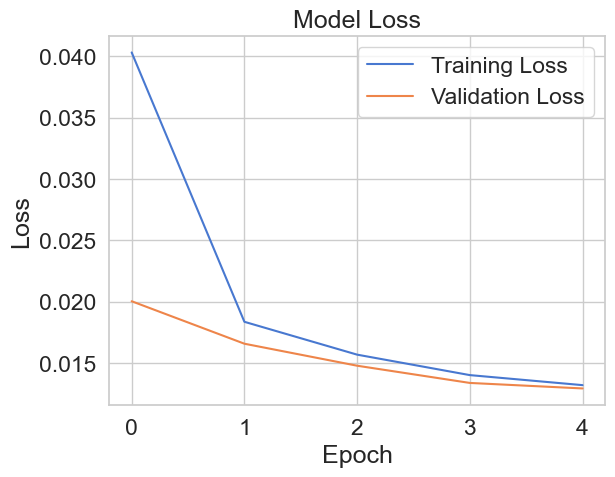

In [6]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
callback = EarlyStopping(monitor='val_loss', patience=3)
checkpointer = ModelCheckpoint(filepath="DAGMM_AE",
                               monitor='val_loss',
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

batch_size = 4
nb_epochs = 5
history = autoencoder.fit(X_train, X_train,
                        epochs=nb_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.4,
                        callbacks=[checkpointer, tensorboard]).history

autoencoder.summary()

plt.plot(range(nb_epochs), history['loss'], label='Training Loss')
plt.plot(range(nb_epochs), history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
# Use the trained autoencoder to encode the training data
encoded_data = autoencoder.encoder(X_train).numpy()

# Fit a Gaussian Mixture Model with 2 components to the encoded training data
gmm = GaussianMixture(n_components=1)
gmm.fit(encoded_data)
saved_gmm = joblib.dump(gmm, 'DAGMM_GMM.pkl')

In [15]:
# Use the GMM to predict the probability densities for the encoded test data
encoded_test_data = autoencoder.encoder(X_test).numpy()
scores = gmm.score_samples(encoded_test_data) # score_samples: PDF of the test data

# Identify anomalies based on the GMM probability densities
threshold = np.percentile(scores, 11.6)
anomalies = X_test[scores < threshold]
print("scores :", scores)
print("threshold :", threshold)
print("anomalies :", anomalies)
print("scores < threshold :", scores < threshold)

scores : [   11.41977972     8.26809338 -1176.01215747 ... -1849.92432421
    11.23543746     9.5889789 ]
threshold : -9.155795331662572
anomalies : [[ 2.11539347e-01  4.85686393e-01  7.27976121e-01 ... -3.48574832e+00
   4.37398851e-01 -1.71779201e+01]
 [ 5.87153269e-02  4.21239625e-01  8.05873035e-01 ...  4.86389554e-01
   4.05856415e-01  1.24688697e+01]
 [ 3.78747430e-01  1.15744756e-01  2.21431157e-01 ... -8.58945877e-01
   8.22963704e-01  1.43450058e+02]
 ...
 [ 3.50099262e-01  1.43091601e-01  2.73748374e-01 ...  5.07334013e-01
   5.16154033e-01  1.36288758e+02]
 [ 3.51043585e-01  9.03234096e-01  9.99999976e-01 ... -3.00923420e+00
   5.16154033e-01 -5.43163815e+02]
 [ 3.60623079e-01  1.33045822e-01  2.54529806e-01 ...  5.07334013e-01
   5.16154033e-01  1.39399123e+02]]
scores < threshold : [False False  True ...  True False False]


In [35]:
# Calculate precision, recall, and F1 score
y_pred = np.zeros_like(scores)
y_pred[scores < threshold] = 1
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}")

Precision: 0.9867, Recall: 0.9860, F1 score: 0.9864


[0.11615385 0.98674521 1.        ]
[1.         0.98601913 0.        ]
[0. 1.]
[0.         0.00174064 1.        ]
[0.         0.98601913 1.        ]
[2. 1. 0.]
(3,) (3,) (2,)


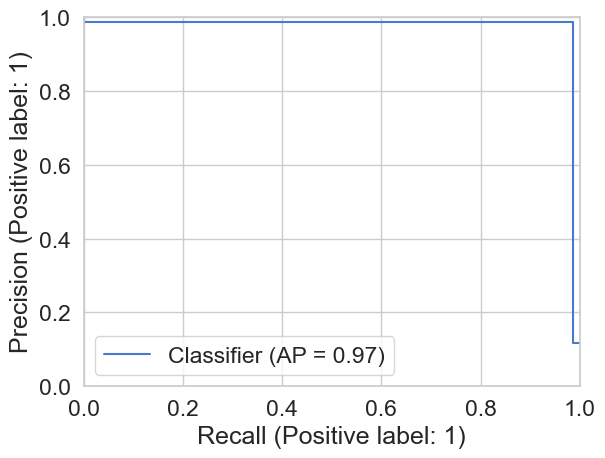

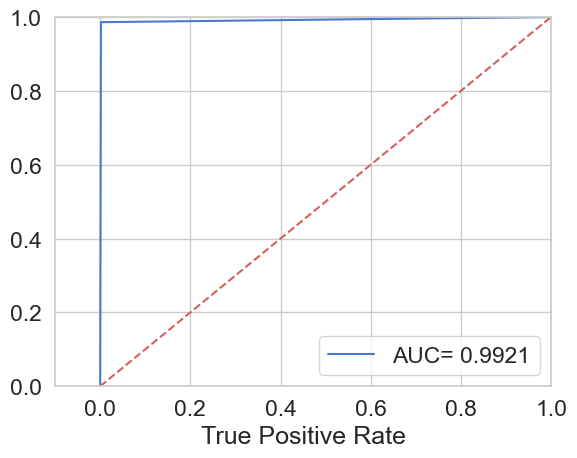

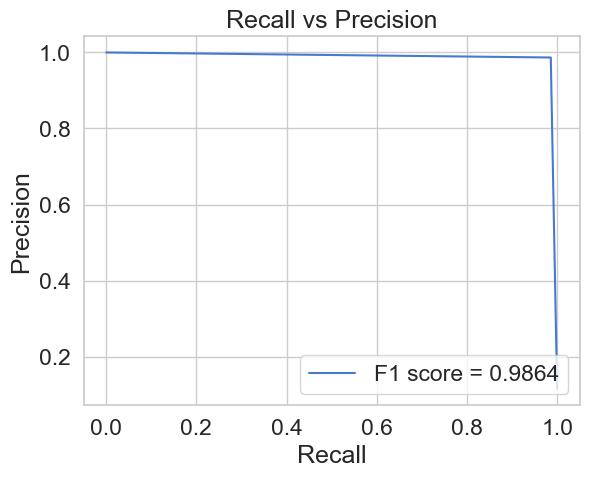

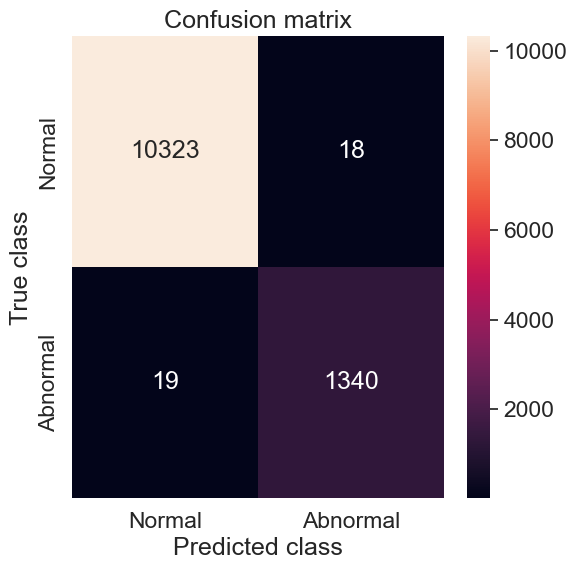

In [34]:
# Calculate precision, recall, and F1 score
y_pred = np.zeros_like(scores)
y_pred[scores < threshold] = 1
precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds2 = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
f1 = f1_score(y_test, y_pred)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
plt.plot(ax=None,name=None)
plt.xlim([-0.001, 1.0])
plt.ylim([0.0, 1.001])

print(precision)
print(recall)
print(thresholds1)
print(fpr)
print(tpr)
print(thresholds2)
print(precision.shape, recall.shape, thresholds1.shape)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, 'b', label='AUC= %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.001])
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.show();

# precision recall curve
plt.figure()
plt.plot(recall, precision, 'b', label='F1 score = %0.4f'% f1)
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show();

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
LABELS = ["Normal", "Abnormal"]
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()